In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon
import pandas as pd
from src.preprocess import *
from tqdm import tqdm

In [2]:
pictures = gpd.read_file("data/podzial_na_obrazki.csv")
noise_barriers_1 = gpd.read_file('data/NOISE_BARRIERS.zip')
noise_barriers_2 = gpd.read_file('data/NOISE_BARRIERS_2.zip')

In [3]:
noise_barriers_1.drop(columns='ID_CLONA', inplace=True)
noise_barriers_2.drop(columns='ID_VAL', inplace=True)

noise_barriers = pd.concat([noise_barriers_1, noise_barriers_2]).reset_index(drop = True)

In [4]:
pictures = gpd.GeoDataFrame(pictures).rename(columns={0: "geometry"})

In [5]:
pictures["geometry"] = pictures["geometry"].apply(parse_polygon)
df = pictures.dropna(subset=["geometry"])

In [6]:
pictures.set_geometry('geometry', inplace=True)

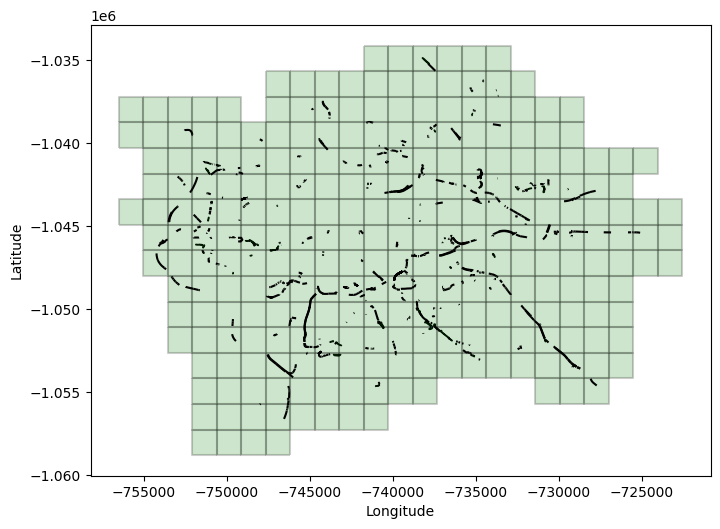

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

noise_barriers.plot(
    k=noise_barriers.shape[0],
    edgecolor="black",
    ax=ax,
)


pictures.plot(ax=ax, alpha = 0.2, color="green",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [8]:
picture = pictures['geometry'][100]

In [9]:
bariers_for_pixel = gpd.clip(noise_barriers, picture)
bariers_for_pixel

,ULICE,POPIS,VYSKA,KAT_UZEMI,GLOBALID,SHAPE_LEN,geometry
33,Pražský okruh,Pražský okruh,2.5,Třebonice,{8AC66918-D19A-4936-8A09-82067F465032},147.214506,"LINESTRING (-753668.289 -1047602.307, -753693...."
32,Pražský okruh,Pražský okruh,2.5,Třebonice,{64DC7777-A23B-421F-8586-F81209061FC3},619.356144,"LINESTRING (-753779.583 -1047508.137, -753781...."
484,Pražský okruh,None,3.0,Třebonice,{4AE00C58-856F-43DB-81B1-41BBC4D761AB},404.699366,"LINESTRING (-754166.627 -1047037.674, -754190...."


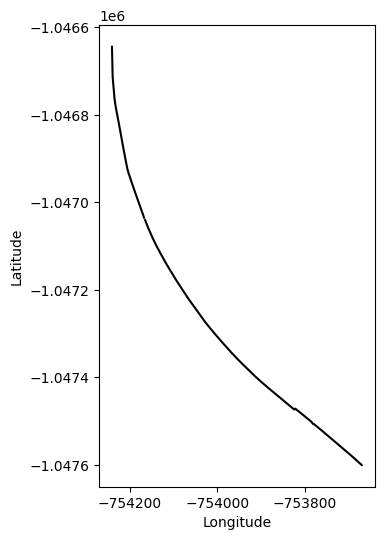

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

bariers_for_pixel.plot(ax=ax, alpha = 1, color="black",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [11]:
pixels = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)

In [12]:
pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
pixels.set_geometry('geometry', inplace=True)

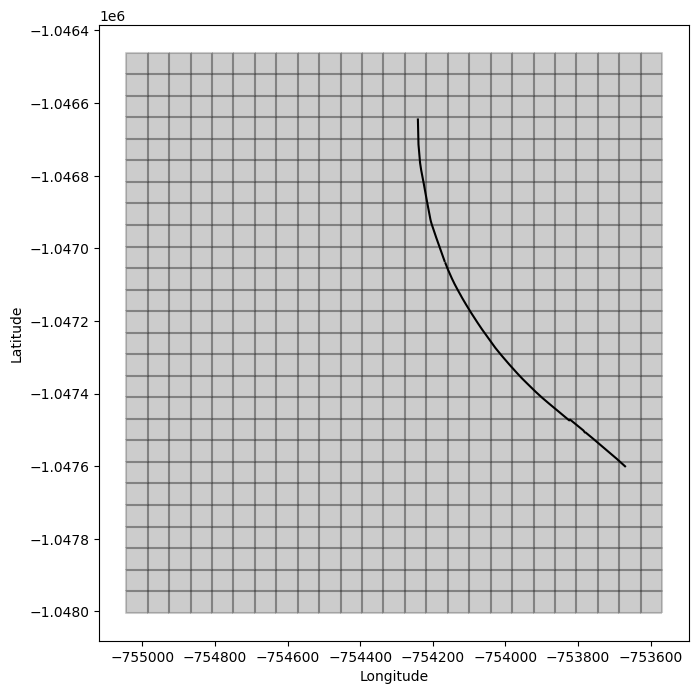

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

bariers_for_pixel.plot(ax=ax, alpha = 1, color="black",edgecolor="black", linewidth=1.5)
pixels.plot(ax=ax, alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [14]:
pixels['has_barier'] = pixels.geometry.apply(
    lambda square: 1 if bariers_for_pixel.geometry.intersects(square).any() else 0
)


In [15]:
pixels

,geometry,has_barier
0,"POLYGON ((-753568.123 -1048003.701, -753627.16...",0
1,"POLYGON ((-753627.168 -1048003.701, -753686.21...",0
2,"POLYGON ((-753686.214 -1048003.701, -753745.25...",0
3,"POLYGON ((-753745.259 -1048003.701, -753804.30...",0
4,"POLYGON ((-753804.305 -1048003.701, -753863.35...",0
...,...,...
645,"POLYGON ((-753863.35 -1046461.43, -753804.305 ...",0
646,"POLYGON ((-753804.305 -1046461.43, -753745.259...",0
647,"POLYGON ((-753745.259 -1046461.43, -753686.214...",0
648,"POLYGON ((-753686.214 -1046461.43, -753627.168...",0


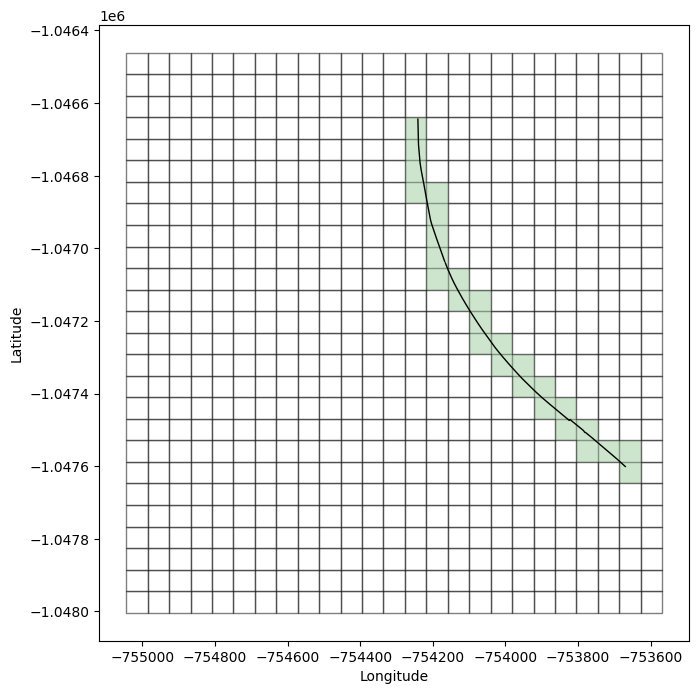

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

bariers_for_pixel.plot(ax=ax, color="black", linewidth=1)
pixels[pixels['has_barier'] == 1].plot(ax=ax, color="green", edgecolor="black", alpha=0.2)
pixels[pixels['has_barier'] == 0].plot(ax=ax, color="white", edgecolor="black", alpha=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

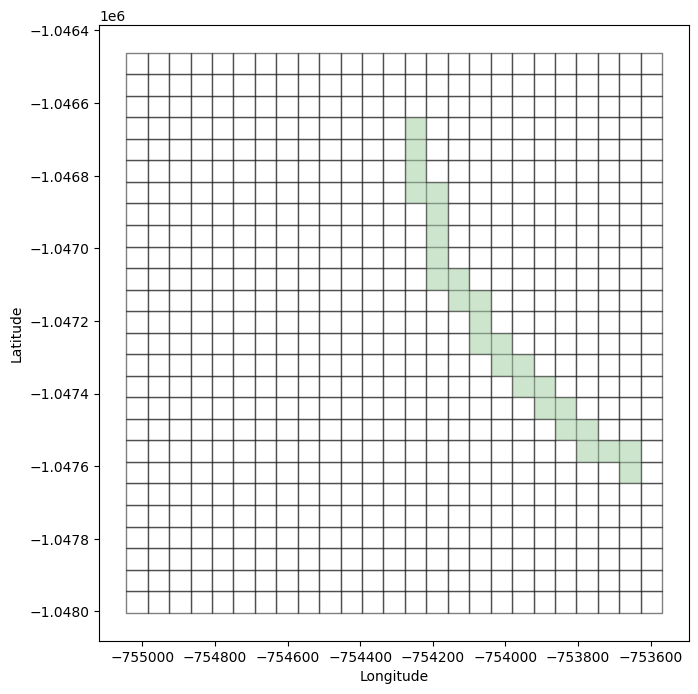

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

pixels[pixels['has_barier'] == 1].plot(ax=ax, color="green", edgecolor="black", alpha=0.2, label="Squares with Roads")
pixels[pixels['has_barier']== 0].plot(ax=ax, color="white", edgecolor="black", alpha=0.5, label="Squares without Roads")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [18]:
def aggregate_noise_barier_data(picture):
    bariers_for_pixel = gpd.clip(noise_barriers, picture)
    pixels = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)
    pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
    pixels.set_geometry('geometry', inplace=True)
    pixels['has_barier'] = pixels.geometry.apply(
        lambda square: 1 if bariers_for_pixel.geometry.intersects(square).any() else 0
    )
    return pixels

In [19]:
bariers_for_pixel = gpd.clip(noise_barriers, picture)

In [20]:
def plot_agg(picture, pixels):
    fig, ax = plt.subplots(figsize=(8, 8))

    bariers_for_pixel = gpd.clip(noise_barriers, picture)
    bariers_for_pixel.plot(ax=ax, color="black", linewidth=1)
    pixels[pixels['has_barier'] == 1].plot(ax=ax, color="green", edgecolor="black", alpha=0.2)
    pixels[pixels['has_barier']== 0].plot(ax=ax, color="white", edgecolor="black", alpha=0.5)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.show()

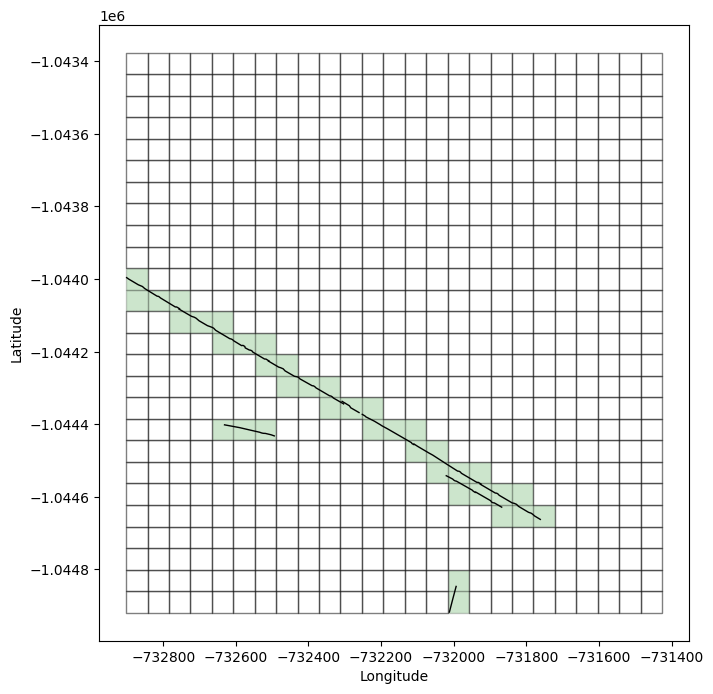

In [21]:
p2 = pictures['geometry'][160]
p = aggregate_noise_barier_data(p2)
plot_agg(p2, p)

In [22]:
counter = 0
for i in tqdm(range(pictures.shape[0])):
    picture = pictures['geometry'][i]
    agg_data = aggregate_noise_barier_data(picture)
    if sum(agg_data['has_barier'] == 1) > 0:
        counter += 1

100%|██████████| 262/262 [07:24<00:00,  1.70s/it]


In [23]:
counter

137

----------

In [ ]:
import osmnx as ox
import geopandas as gpd

# Pobranie danych o budynkach w Pradze
place_name = "Prague, Czech Republic"
buildings = ox.features_from_place(place_name, tags={"building": True})

# Filtrowanie tylko budynków z wysokością lub liczbą kondygnacji
buildings = buildings[(buildings["height"].notna()) | (buildings["building:levels"].notna())]

# Konwersja wysokości i liczby kondygnacji na numeryczne wartości
buildings["height"] = pd.to_numeric(buildings["height"], errors='coerce')
buildings["building:levels"] = pd.to_numeric(buildings["building:levels"], errors='coerce')

# Wyświetlenie pierwszych kilku wierszy
print(buildings[["height", "building:levels"]].head())

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f454649fa60>>
Traceback (most recent call last):
  File "/home/natalia/GeoNoise/spatial/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [115]:
import osmnx as ox


city = 'Praha'
buildings = ox.features_from_place(city, tags={'building': True})

In [116]:
buildings.columns

Index(['geometry', 'building', 'name', 'ruins', 'website',
       'addr:conscriptionnumber', 'addr:housenumber', 'addr:postcode',
       'addr:street', 'addr:streetnumber',
       ...
       'language:teaching:fr', 'ref:ruian:building_1', 'name:pt', 'name:ro',
       'was:building:material', 'tunnel', 'climbing:bolted', 'climbing:length',
       'climbing:sport', 'secondary_use'],
      dtype='object', length=621)

In [117]:
buildings["building:levels"].isna().count()

np.int64(172561)

In [118]:
buildings.shape

(172561, 621)

In [119]:
buildings[['geometry', 'building:levels', 'height']]

geometry  \
element id                                                              
node    28557599                            POINT (14.55278 50.15711)   
        296790769                           POINT (14.47671 50.07288)   
        308726263                           POINT (14.39168 50.10333)   
        449759142                            POINT (14.4581 50.07325)   
        1853491744                          POINT (14.42276 49.97625)   
...                                                               ...   
way     1354431994  POLYGON ((14.49671 50.10199, 14.49674 50.10206...   
        1354431995  POLYGON ((14.49671 50.10199, 14.49583 50.10213...   
        1354431996  POLYGON ((14.49604 50.10223, 14.49606 50.10228...   
        1355007664  POLYGON ((14.36267 49.98414, 14.36264 49.98416...   
        1355204881  POLYGON ((14.48843 50.07757, 14.48857 50.07759...   

                   building:levels height  
element id                                 
node    28557599               NaN    NaN  
        296790769              NaN    NaN  
        308726263              NaN    NaN  
        449759142                3    NaN  
        1853491744             NaN     35  
...                            ...    ...  
way     1354431994             NaN    NaN  
        1354431995             NaN    NaN  
        1354431996             NaN    NaN  
        1355007664             NaN    NaN  
        1355204881               1    NaN  

[172561 rows x 3 columns]

In [120]:
buildings = buildings[(buildings["building:levels"].notna())]

In [121]:
buildings = buildings[['geometry', 'building:levels']]

In [122]:
buildings.dtypes

geometry           geometry
building:levels      object
dtype: object

In [123]:
buildings["building:levels"] = pd.to_numeric(buildings["building:levels"], errors='coerce')

In [124]:
buildings.isna().sum()

geometry           0
building:levels    2
dtype: int64

In [125]:
buildings = buildings[buildings["building:levels"].notna()]

In [126]:
buildings.isna().sum()

geometry           0
building:levels    0
dtype: int64

In [127]:
buildings

geometry  \
element  id                                                              
node     449759142                            POINT (14.4581 50.07325)   
relation 2162        POLYGON ((14.4491 50.11515, 14.4491 50.11511, ...   
         2610        POLYGON ((14.399 50.09999, 14.39873 50.10014, ...   
         5210        POLYGON ((14.49153 50.02408, 14.49154 50.02408...   
         19353       POLYGON ((14.43432 50.02396, 14.43251 50.02463...   
...                                                                ...   
way      1353603716  POLYGON ((14.52344 50.05149, 14.52349 50.05144...   
         1353641596  POLYGON ((14.49456 50.1183, 14.49467 50.11829,...   
         1353986393  POLYGON ((14.28668 50.05533, 14.28674 50.05535...   
         1354185328  POLYGON ((14.46103 50.06067, 14.4612 50.06062,...   
         1355204881  POLYGON ((14.48843 50.07757, 14.48857 50.07759...   

                     building:levels  
element  id                           
node     449759142               3.0  
relation 2162                    2.0  
         2610                    5.0  
         5210                    3.0  
         19353                   4.0  
...                              ...  
way      1353603716              4.0  
         1353641596              1.0  
         1353986393              1.0  
         1354185328              1.0  
         1355204881              1.0  

[108389 rows x 2 columns]

In [128]:
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [129]:
buildings = buildings.rename(columns={'building:levels': 'buildings_level'})

In [130]:
buildings

geometry  \
element  id                                                              
relation 2162        POLYGON ((14.4491 50.11515, 14.4491 50.11511, ...   
         2610        POLYGON ((14.399 50.09999, 14.39873 50.10014, ...   
         5210        POLYGON ((14.49153 50.02408, 14.49154 50.02408...   
         19353       POLYGON ((14.43432 50.02396, 14.43251 50.02463...   
         19986       POLYGON ((14.39024 50.10308, 14.39017 50.10303...   
...                                                                ...   
way      1353603716  POLYGON ((14.52344 50.05149, 14.52349 50.05144...   
         1353641596  POLYGON ((14.49456 50.1183, 14.49467 50.11829,...   
         1353986393  POLYGON ((14.28668 50.05533, 14.28674 50.05535...   
         1354185328  POLYGON ((14.46103 50.06067, 14.4612 50.06062,...   
         1355204881  POLYGON ((14.48843 50.07757, 14.48857 50.07759...   

                     buildings_level  
element  id                           
relation 2162                    2.0  
         2610                    5.0  
         5210                    3.0  
         19353                   4.0  
         19986                   5.0  
...                              ...  
way      1353603716              4.0  
         1353641596              1.0  
         1353986393              1.0  
         1354185328              1.0  
         1355204881              1.0  

[108388 rows x 2 columns]

In [131]:
buildings = buildings.to_crs(noise_barriers.crs)

<Axes: >

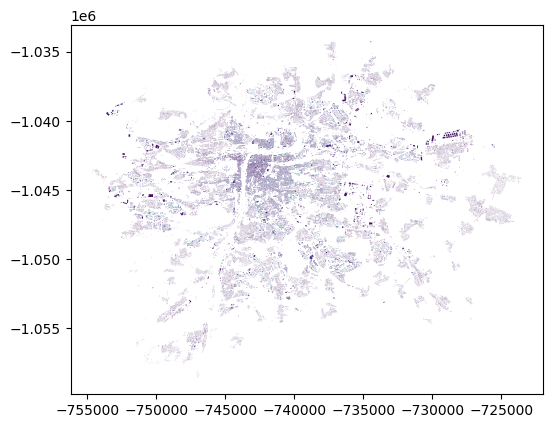

In [135]:
buildings.plot(
    column = 'buildings_level',
    cmap = 'viridis'
)

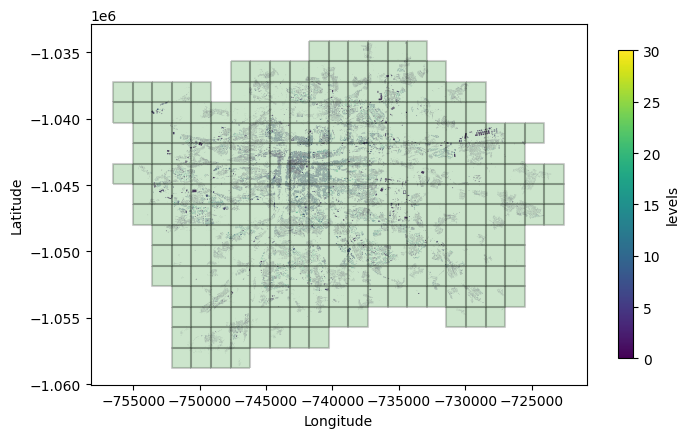

In [189]:

fig, ax = plt.subplots(figsize=(8, 8))

buildings.plot(column='buildings_level', 
        cmap='viridis',
        legend=True,
        alpha=0.9, 
        ax=ax,
        legend_kwds={'shrink': 0.5, 'label': 'levels'}
)


pictures.plot(ax=ax, alpha = 0.2, color="green",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [140]:
picture = pictures['geometry'][1]

In [175]:
buildings_for_pixel = gpd.clip(buildings, picture)
p1 = split_polygon(picture, thresh=0.99, number_of_pixels_on_side = 25)


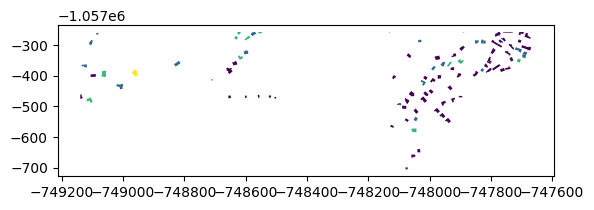

In [176]:
buildings_for_pixel.plot(column='buildings_level');

In [177]:
p1 = geopandas.GeoDataFrame(p1).rename(columns={0: "geometry"})
p1.set_geometry('geometry', inplace=True)

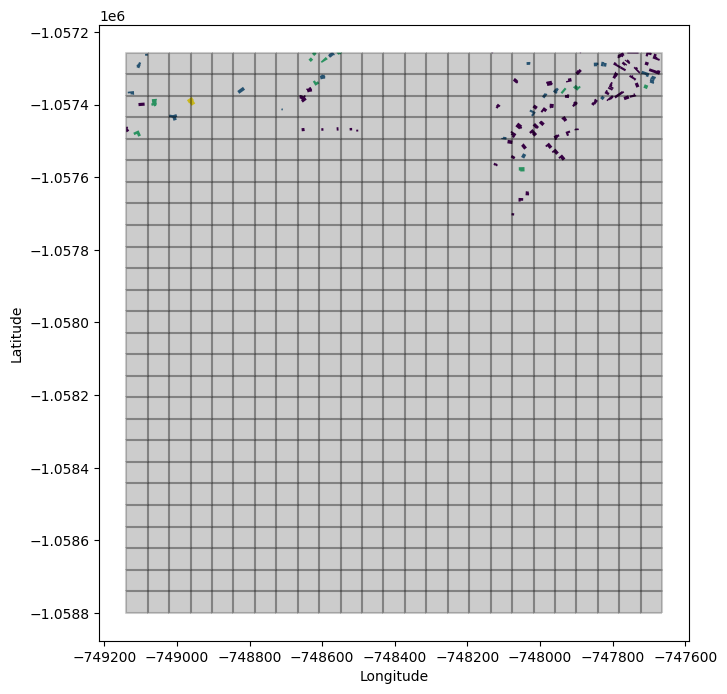

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))

buildings_for_pixel.plot(ax=ax,column='buildings_level')
p1.plot(ax=ax, alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [183]:
def get_buildings_levels(pixel):
    intersecting_buildings = buildings_for_pixel[buildings_for_pixel.geometry.intersects(pixel)]
    
    if not intersecting_buildings.empty:
        intersecting_buildings = intersecting_buildings.to_crs(epsg=2180)
        intersecting_buildings["area"] = intersecting_buildings.geometry.area
        area_by_levels = intersecting_buildings.groupby('buildings_level')["area"].sum()
        max_levels = area_by_levels.idxmax()
        return max_levels
    
    else:
        return 0 

In [184]:
p1

,geometry
0,"POLYGON ((-747663.568 -1058799.6, -747722.613 ..."
1,"POLYGON ((-747722.613 -1058799.6, -747781.659 ..."
2,"POLYGON ((-747781.659 -1058799.6, -747840.704 ..."
3,"POLYGON ((-747840.704 -1058799.6, -747899.75 -..."
4,"POLYGON ((-747899.75 -1058799.6, -747958.796 -..."
...,...
645,"POLYGON ((-747958.796 -1057257.329, -747899.75..."
646,"POLYGON ((-747899.75 -1057257.329, -747840.704..."
647,"POLYGON ((-747840.704 -1057257.329, -747781.65..."
648,"POLYGON ((-747781.659 -1057257.329, -747722.61..."


In [186]:
p1['buildings_level'] = p1.geometry.apply(get_buildings_levels)

In [187]:
p1

,geometry,buildings_level
0,"POLYGON ((-747663.568 -1058799.6, -747722.613 ...",0.0
1,"POLYGON ((-747722.613 -1058799.6, -747781.659 ...",0.0
2,"POLYGON ((-747781.659 -1058799.6, -747840.704 ...",0.0
3,"POLYGON ((-747840.704 -1058799.6, -747899.75 -...",0.0
4,"POLYGON ((-747899.75 -1058799.6, -747958.796 -...",0.0
...,...,...
645,"POLYGON ((-747958.796 -1057257.329, -747899.75...",1.0
646,"POLYGON ((-747899.75 -1057257.329, -747840.704...",1.0
647,"POLYGON ((-747840.704 -1057257.329, -747781.65...",1.0
648,"POLYGON ((-747781.659 -1057257.329, -747722.61...",1.0


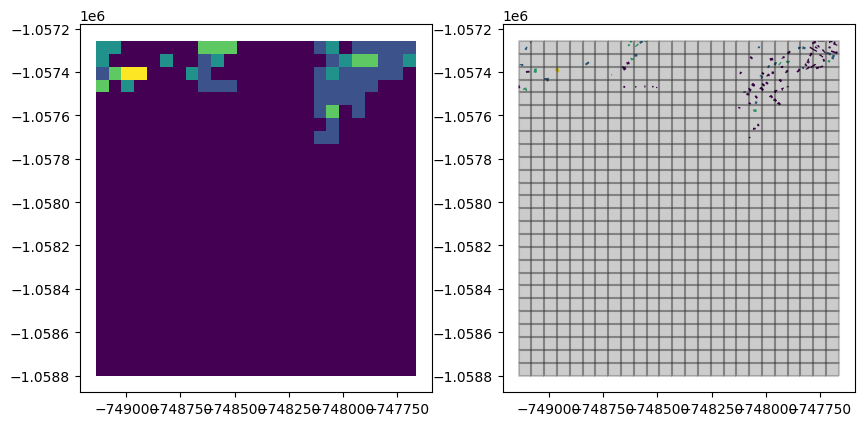

In [195]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))

# pixels.plot(
#     column="weighted_db_hi",
#     cmap="hot_r",
#     scheme="quantiles",
#     k=noise.shape[0],
#     edgecolor="white",
#     linewidth=0.0,
#     alpha=1,
#     #legend=True,
#     #legend_kwds=dict(loc=2),
#     ax=ax[0],
# )

p1.plot(column='buildings_level',cmap="viridis", ax=ax[0], linewidth=0.0, edgecolor="0.8")

buildings_for_pixel.plot(
    column="buildings_level",
    cmap="viridis",
    linewidth=0.0,
    alpha=1,
    #legend=True,
    #legend_kwds=dict(loc=2),
    ax=ax[1],
)

p1.plot(ax=ax[1], alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)


# roads_for_pixel.plot(ax=ax, alpha = 1, color="black",edgecolor="black", linewidth=1.5)
# pixels.plot(ax=ax, alpha = 0.2, color="black",edgecolor="black", linewidth=1.5)

# Add a legend
#ax.legend()

# Add title and labels
#ax.set_title("Noise Map and Public Transportation Lines")
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")

# Show the map
plt.show()